# Import relevant libraries

In [55]:
%%time
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from gensim.models import Word2Vec

from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale

import keras 
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

CPU times: user 1.09 ms, sys: 7.14 ms, total: 8.23 ms
Wall time: 158 ms


In [56]:
%%time
path = '../data/'
fn = 'substance_interactions.csv'

rawData = pd.read_csv(path+fn)
dataSentence = rawData[['SENTENCE', 'LABEL']]
rawData['cleanedPredicate'] = rawData.PREDICATE.apply(lambda x: x.replace('_', ' '))

rawData['subjectPredicateObject'] = rawData[['SUBJECT_TEXT', 'cleanedPredicate', 'OBJECT_TEXT']].agg(' '.join, axis=1)
rawData['NewSentence'] = rawData[['subjectPredicateObject', 'SENTENCE']].agg(' '.join, axis=1)
dataCombo = rawData[['NewSentence', 'LABEL']]
dataCombo.columns = ['SENTENCE', 'LABEL']

dataSubPredObj = rawData[['subjectPredicateObject', 'LABEL']]
dataSubPredObj.columns = ['SENTENCE', 'LABEL']

'''
The next line should be edited based on choice of input.
Use data = dataSentence
If => Input = 'SENTENCE'

Use data = dataCombo
If => Input = 'SUBJECT_TEXT'+ 'PREDICATE'+ 'OBJECT_TEXT' + 'SENTENCE'

Use data = dataSubPredObj
If => Input = 'SUBJECT_TEXT'+ 'PREDICATE'+ 'OBJECT_TEXT'
'''
data = dataCombo # OPTIONS: dataSentence, dataSubPredObj, dataCombo 
data.head()

CPU times: user 554 ms, sys: 35.1 ms, total: 589 ms
Wall time: 765 ms


,SENTENCE,LABEL
0,SA INTERACTS WITH ASA Nor did administration o...,n
1,rHF INHIBITS oxidase A comparative study...,n
2,alkaloids INHIBITS aromatase These findings su...,y
3,amino acids INTERACTS WITH Jak1 With a t...,y
4,Neutral endopeptidase STIMULATES thermol...,n


# Functions

In [57]:
'''
This function just cleans and tokenizes the input text and I converted 
the labels into a Boolean.
'''
def tokenization(d):
    tokenizer = RegexpTokenizer(r'\w+') # tokenizes only a-z,A-Z,0-9 and '_'
    d['cleanSentence'] = d['SENTENCE'].astype('str')

    d["tokens"] = d['cleanSentence'].apply(tokenizer.tokenize)
    d["labels"] = (d['LABEL'] != 'n').astype(int)

    return d

'''
This function assigns each token (row) a (1x300) array of numbers obtained from 
the Google News Vectors (w2v) binary file dataset. Alternatively, I could 
have used GloVe (Global Vectors for Word Representation) for getting vectors
for the words. I chose word2vec arbitrarily due to time constraint.
'''
def buildWordVector(tokens, size):
    vect = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vect += w2vModel[word].reshape((1, size)) * tfidf[word]
            count += 1
        except KeyError:
            # If token not in corpus
            continue
    if count > 0:
        vect /= count
    return vect

'''
This function returns a graphical chart of the accuracy and loss function
of the predictions.
'''

def plotPredictions(predictions, accu):
    accur = predictions.history[accu]
    valAccur = predictions.history['val_'+accu]
    loss = predictions.history['loss']
    valLoss = predictions.history['val_loss']
    x = range(1, len(accur) + 1)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, accur, 'b', label='Training Accuracy')
    plt.plot(x, valAccur, 'r', label='Testing Accuracy')
    plt.title('Training-Testing Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training Loss')
    plt.plot(x, valLoss, 'r', label='Testing Loss')
    plt.title('Training-Testing Loss')
    plt.legend()

'''
This function returns the F-score 
from precision(p) and recall(r)
'''
def calculateFScore(p, r):
    return 2*p*r/(p+r)

# Preprocessing

## Tokenization

In [58]:
tokenized = tokenization(data)
tokenized.head()

,SENTENCE,LABEL,cleanSentence,tokens,labels
0,SA INTERACTS WITH ASA Nor did administration o...,n,SA INTERACTS WITH ASA Nor did administration o...,"[SA, INTERACTS, WITH, ASA, Nor, did, administr...",0
1,rHF INHIBITS oxidase A comparative study...,n,rHF INHIBITS oxidase A comparative study...,"[rHF, INHIBITS, oxidase, A, comparative, study...",0
2,alkaloids INHIBITS aromatase These findings su...,y,alkaloids INHIBITS aromatase These findings su...,"[alkaloids, INHIBITS, aromatase, These, findin...",1
3,amino acids INTERACTS WITH Jak1 With a t...,y,amino acids INTERACTS WITH Jak1 With a t...,"[amino, acids, INTERACTS, WITH, Jak1, With, a,...",1
4,Neutral endopeptidase STIMULATES thermol...,n,Neutral endopeptidase STIMULATES thermol...,"[Neutral, endopeptidase, STIMULATES, thermolys...",0


## Import pretrained model from Google

[https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz]

In [69]:
%%time
import gensim
w2vModel = gensim.models.KeyedVectors.load_word2vec_format('../model/GoogleNews-vectors-negative300.bin.gz', binary=True)

CPU times: user 3min 50s, sys: 23.9 s, total: 4min 14s
Wall time: 12min 49s


## Vocabulary Building

In [44]:
%%time
y = tokenized['labels'] # expected output
x = np.array(tokenized['tokens']) #input

# Train-Test split using sklearn. I chose the split to be 80-20% (training-testing)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state=0)

CPU times: user 3.39 ms, sys: 3.68 ms, total: 7.07 ms
Wall time: 6.19 ms


In [59]:
%%time

# TF-IDF [Term Frequency - Inverse Document Frequency] to form vocabulary.
# Using 'TfidfVectorizer' from sklearn

vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in xTrain])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('VocabSize:', len(tfidf))

VocabSize: 813
CPU times: user 61.2 ms, sys: 16.4 ms, total: 77.6 ms
Wall time: 160 ms


## Vector Building for training and test set

In [60]:
%%time
# training set
trainVecsW2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, xTrain)])
trainVecsW2v = scale(trainVecsW2v) # standardizing the data around mean with unit variance

# testing set
testVecsW2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, xTest)])
testVecsW2v = scale(testVecsW2v)# standardizing the data around mean with unit variance

print('trainingSetShape:', trainVecsW2v.shape, ', testingSetShape:', testVecsW2v.shape)

trainingSetShape: (2400, 300) , testingSetShape: (600, 300)
CPU times: user 1.32 s, sys: 268 ms, total: 1.58 s
Wall time: 1.79 s


# Building a Neural Network

## Here I wanted to first run through a neural network with the following design:



1.   Two Dense layers (DL 1 and 2)
2.   Activation Functions:

> a. ReLU (Rectified Linear Unit) (for DL 1)

> b. Sigmoid (for DL 2)


3.   Dropout (on DL 1): varied it from 0.2 to 0.9
4.   Optimizer: I tried 3 different ones as seen in the code.


> a. Adadelta

> b. Adam (Adaptive Moment Estimation)

> c. Stochastic Gradient Descent (SGD). In the interest of time, I stopped at 3. RMSprop could be another worth a shot.


5.   Loss: Binary Cross Entropy. Could have used mean squared error (mse) too.


## Model design

In [61]:
model = Sequential()

model.add(Dense(256, activation='relu', input_dim=300))
'''
Ideally dropout should be between 0.2 and 0.8 
but 0.9 yielded better results in this case.
I noticed a lot of overfitting as the value
was close to the lower end which reduced as
it approached 0.9
'''
model.add(Dropout(0.9)) # Regularization technique to avoid overfitting
model.add(Dense(1, activation='sigmoid')) # Sigmoid works better than Adam and adadelta

'''
SGD (Stochastic gradient descent) seemed to give the best results out of the 3 
optimizers used. The choice for these three were arbitrary. I limited it to
3 due to time constraints. I tried tweaking the learning rate but 0.01 seemed
to give slightly better results. I changed momentum between 0.3 to 0.8 and 0.5
seemed to do a good job.
'''
#opt = keras.optimizers.Adam(learning_rate=1e-2)
#opt = 'adadelta'
opt = SGD(lr=1e-2, momentum=0.5)

model.compile(optimizer=opt, loss='binary_crossentropy', \
              metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 77,313
Trainable params: 77,313
Non-trainable params: 0
_________________________________________________________________


## Train the network

Train on 2400 samples, validate on 600 samples
Epoch 1/10
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1697 - accuracy: 0.5396 - precision_1: 0.5716 - recall_1: 0.6089 - val_loss: 0.7128 - val_accuracy: 0.5883 - val_precision_1: 0.5692 - val_recall_1: 0.7375
Epoch 2/10
2400/2400 [==============================] - 1s 218us/step - loss: 1.0389 - accuracy: 0.5446 - precision_1: 0.5793 - recall_1: 0.5913 - val_loss: 0.7194 - val_accuracy: 0.5850 - val_precision_1: 0.5602 - val_recall_1: 0.8040
Epoch 3/10
2400/2400 [==============================] - 1s 388us/step - loss: 0.8917 - accuracy: 0.5708 - precision_1: 0.6004 - recall_1: 0.6281 - val_loss: 0.7039 - val_accuracy: 0.5950 - val_precision_1: 0.5700 - val_recall_1: 0.7841
Epoch 4/10
2400/2400 [==============================] - 1s 306us/step - loss: 0.8119 - accuracy: 0.5633 - precision_1: 0.5943 - recall_1: 0.6189 - val_loss: 0.6871 - val_accuracy: 0.5983 - val_precision_1: 0.5714 - val_recall_1: 0.7973
Epoch 5/10


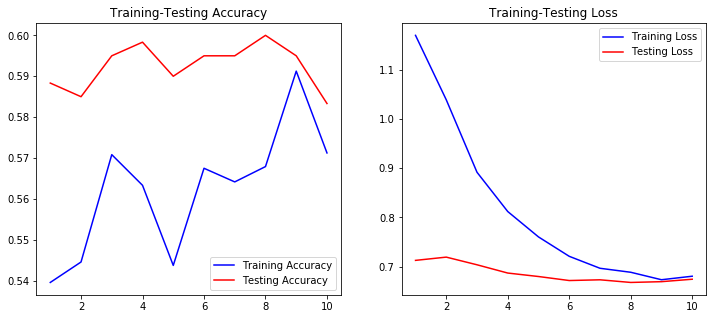

In [62]:
%%time
# I ran it with 20 epochs too with not much improvement so kept it at 10.
predictions = model.fit(trainVecsW2v, yTrain, epochs=10, batch_size=100, validation_data=(testVecsW2v, yTest))

loss, accuracy, precision, recall = model.evaluate(trainVecsW2v, yTrain, verbose=False)
print('==========Training Metrics============')
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F-score: {:.4f}'.format(calculateFScore(precision, recall)))
print('======================================')

loss, accuracy, precision, recall = model.evaluate(testVecsW2v, yTest, verbose=False)
print('==========Testing Metrics============')
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F-score: {:.4f}'.format(calculateFScore(precision, recall)))
print('======================================')

plotPredictions(predictions,'accuracy')

# CNN

## Word and sentence stats

In [63]:
allWords = [word for tokens in tokenized['tokens'] for word in tokens]
allSentenceLengths = [len(tokens) for tokens in tokenized['tokens']]
allVocab = sorted(list(set(allWords)))

embeddingDimension = 300 # this is the size of the w2v vector.
maxVocabSize = len(allVocab)
maxSequenceLength = max(allSentenceLengths) # max words per row in the 'SENTENCE' column.
print('%s words total, with a vocabulary size of %s' % (len(allWords), maxVocabSize))
print('Max sentence length is %s' % maxSequenceLength)

89904 words total, with a vocabulary size of 10437
Max sentence length is 157


## Embedding Matrix generation

In [70]:
%%time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Using a keras tokenizer this time instead of the previous one.
tokenizer2 = Tokenizer(num_words=maxVocabSize, lower=True, char_level=False)
tokenizer2.fit_on_texts(data['SENTENCE'].tolist())

trainingSequences = tokenizer2.texts_to_sequences(xTrain.tolist())
testSequences = tokenizer2.texts_to_sequences(xTest.tolist())

trainWordIndex = tokenizer2.word_index
print('Found %s unique tokens' % len(trainWordIndex))

trainEmbeddingWeights = np.zeros((len(trainWordIndex)+1, embeddingDimension))
for word, index in trainWordIndex.items():
    trainEmbeddingWeights[index,:] = w2vModel[word] \
    if word in w2vModel else np.random.rand(embeddingDimension)
    
print('Embedding Matrix Shape:',trainEmbeddingWeights.shape)

'''
Training and testing set after zero-padding
'''

trainDataCNN = pad_sequences(trainingSequences, maxlen=maxSequenceLength)
testDataCNN = pad_sequences(testSequences, maxlen=maxSequenceLength)
print('Training data shape:', trainDataCNN.shape)
print('Testing data shape:', testDataCNN.shape)

Found 9331 unique tokens
Embedding Matrix Shape: (9332, 300)
Training data shape: (2400, 157)
Testing data shape: (600, 157)
CPU times: user 686 ms, sys: 2.36 s, total: 3.04 s
Wall time: 1min 45s


## Design CNN 
Some of the parameters were inspired from the paper by Yoon Kim et.al. 
(https://arxiv.org/pdf/1408.5882.pdf) with a few tweaks from me out of curiosity.
1.   Number of convolution layers: 3
2.   Number of dense layers: 2
3.   Number of feature maps: 100
4.   Activation Functions: relu ,and sigmoid for the last dense layer
5.   Filter sizes: 3, 4 and 5
6.   Dropout: varied between 0.2 to 0.9 and settled at 0.5
7.   Optimizer: Same as before, SGD performed the best
8.   Loss: Binary Cross Entropy


In [64]:
from keras.layers import concatenate

def ConvNet(embeddings, maxSequenceLength, numWords, embeddingDimension, multiConv=True):
    
    embeddingLayer = Embedding(numWords,\
                               embeddingDimension,\
                               weights=[embeddings],\
                               input_length=maxSequenceLength)
    sequenceInput = Input(shape=(maxSequenceLength,), dtype='int32')
    embeddedSequences = embeddingLayer(sequenceInput)
    
    convs = []
    '''
    Parameters adopted from the paper by Yoon Kim et. al.. 
    Although he arrived at these by doing a grid search.
    In the interest of time I will just use these numbers.
    '''
    filterSizes = [3,4,5]
    numFeatureMaps = 100
    dropout = 0.5
    
    for filterSize in filterSizes:
        lConv = Conv1D(filters=numFeatureMaps, kernel_size=filterSize, activation='relu')(embeddedSequences)
        lPool = MaxPooling1D(pool_size=3)(lConv)
        convs.append(lPool)
        
    lMerge = concatenate([convs[0],convs[1], convs[2]], axis=1)
    
    conv = Conv1D(filters=numFeatureMaps, kernel_size=3, activation='relu')(embeddedSequences)
    pool = MaxPooling1D(pool_size=3)(conv)
    
    '''
    I wanted to try 1D convNet with global max pooling
    VS
    3 conv layers and corresponding max pool layers.
    The latter gives better results.
    '''
    if multiConv == True:
        x = Dropout(dropout)(lMerge) 
    else:
        x = Dropout(dropout)(pool) 
        
    x = Flatten()(x)
    x = Dense(numFeatureMaps, activation='relu')(x)
    
    preds = Dense(1, activation='sigmoid')(x)
    
    model = Model(sequenceInput, preds)
    #opt = keras.optimizers.Adam(learning_rate=1e-2)
    #opt = 'adadelta'
    opt = SGD(lr=1e-2, momentum=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, \
                  metrics=['acc',keras.metrics.Precision(), keras.metrics.Recall()])
    
    model.summary()
    return model

In [65]:
model2 = ConvNet(trainEmbeddingWeights, maxSequenceLength, len(trainWordIndex)+1, embeddingDimension, multiConv=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 157)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 157, 300)     2799600     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 155, 100)     90100       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 154, 100)     120100      embedding_3[0][0]                
____________________________________________________________________________________________

## Training the model

Train on 2400 samples, validate on 600 samples
Epoch 1/10
2400/2400 [==============================] - 48s 20ms/step - loss: 0.6927 - acc: 0.5267 - precision_2: 0.5662 - recall_2: 0.5506 - val_loss: 0.6643 - val_acc: 0.6033 - val_precision_2: 0.5759 - val_recall_2: 0.7940
Epoch 2/10
2400/2400 [==============================] - 31s 13ms/step - loss: 0.6729 - acc: 0.5979 - precision_2: 0.6132 - recall_2: 0.7040 - val_loss: 0.6577 - val_acc: 0.5967 - val_precision_2: 0.5743 - val_recall_2: 0.7575
Epoch 3/10
2400/2400 [==============================] - 31s 13ms/step - loss: 0.6678 - acc: 0.6025 - precision_2: 0.6138 - recall_2: 0.7239 - val_loss: 0.6545 - val_acc: 0.6033 - val_precision_2: 0.5810 - val_recall_2: 0.7508
Epoch 4/10
2400/2400 [==============================] - 36s 15ms/step - loss: 0.6647 - acc: 0.6054 - precision_2: 0.6154 - recall_2: 0.7301 - val_loss: 0.6515 - val_acc: 0.6117 - val_precision_2: 0.5914 - val_recall_2: 0.7309
Epoch 5/10
2400/2400 [===========================

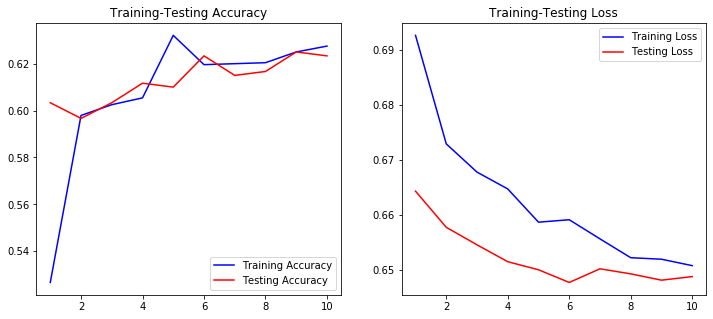

In [66]:
%%time
predictions2 = model2.fit(trainDataCNN, yTrain, epochs=10, batch_size=500, validation_data=(testDataCNN, yTest))

loss, accuracy, precision, recall = model2.evaluate(trainDataCNN, yTrain, verbose=False)
print('==========Training Metrics============')
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F-score: {:.4f}'.format(calculateFScore(precision, recall)))
print('======================================')

loss, accuracy, precision, recall = model2.evaluate(testDataCNN, yTest, verbose=False)
print('==========Testing Metrics============')
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F-score: {:.4f}'.format(calculateFScore(precision, recall)))
print('======================================')

plotPredictions(predictions2, accu='acc')

# Extras

## I was just curious about the most frequently occuring words in the corpus.

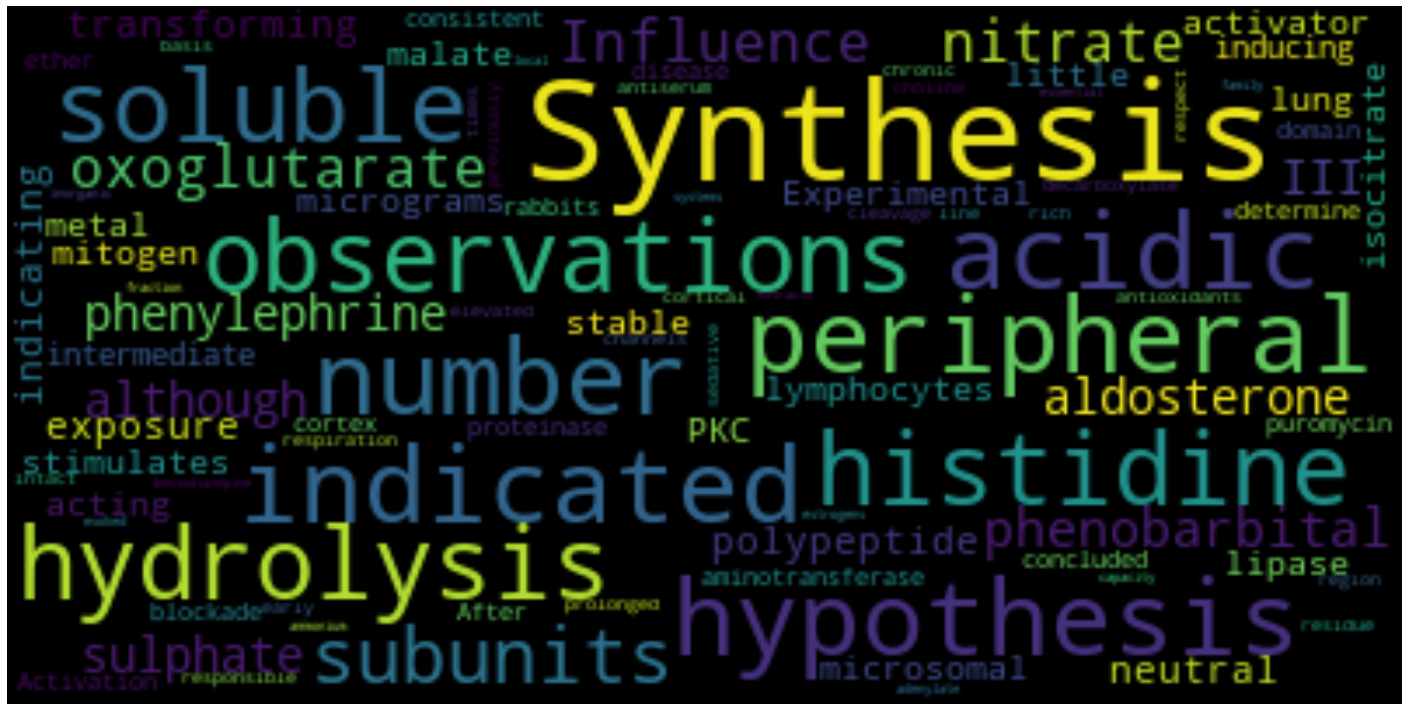

In [67]:
# Wordcloud of top 100 frequently occuring words
from wordcloud import WordCloud

def plotWordCloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    
tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf2.columns = ['tfidf']
plotWordCloud(tfidf2.sort_values(by=['tfidf'], ascending=False).head(100))